<a href="https://colab.research.google.com/github/peggyscshu/CCP-lifetime/blob/main/One_step_CCP_Lifetime_20250227.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
import os
import pandas as pd
import re
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import warnings
import scipy.integrate as integrate
import scipy.optimize
from google.colab import drive

#Define the fitting funcitons
def monoExp(x, a1, t1, b1):
    return a1 * np.exp(-t1 * x) + b1

def duExp(x, a1d, t1d, a2d, t2d, b2):
    return a1d * np.exp(-t1d *x) + a2d * np.exp(-t2d * x) + b2

def tpExp(x, a1t, t1t, a2t, t2t, a3t, t3t, b3):
  return a1t * np.exp(-t1t *x) + a2t * np.exp(-t2t * x) + a3t * np.exp(-t3t * x) + b3

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. CCP LifeTime Analysis
## 1.1 Convert Imaris Tracking Result to Lifetime
## 1.2 Split Imaris tracking results in two folders according to the imaging speed.
## 1.3 Merge slow and fast data for three components exponential fitting. (Here's what we are going to do.)
### 1.3.1 Set following parameters  
      ✅ Add the path for Imaris measurements and output
      ✅ Add the Time interval here
      ✅ Create a folder "CCP_assay" under MyDrive.

In [124]:
#Get the path for loading & saving data------------------------------------------------------------------------------Set input path and interval in this cell.
Raw_path_fast = ("/content/drive/MyDrive/Shared Colab/CCP lifetime analysis_20241229/A_Imaris result/Fast")
Interval_fast = 0.602
Raw_path_slow = ("/content/drive/MyDrive/Shared Colab/CCP lifetime analysis_20241229/A_Imaris result/Slow")
Interval_slow = 2.214

Files = {"Fast":os.listdir(Raw_path_fast),"Slow": os.listdir(Raw_path_slow)}
Files

{'Fast': ['GFP3-2_interval_0p643.xls', 'GFP3-1_interval_0p643.xls'],
 'Slow': ['GFP04-1_interval_2p136.xls', 'GFP04-2_interval_2p136.xls']}

### 1.3.2 Main codes
A. Wrangle Imaris measured data.  
B. Correct track no with the probability (PLoS Biol 7(3):e1000057).  
C. Group datasets from the same speed.  
D. Merge tracks with the same lifttime and get the lifetime probability density function (PDF).  
E. Normalize PDFs from two datasets in different speeds.

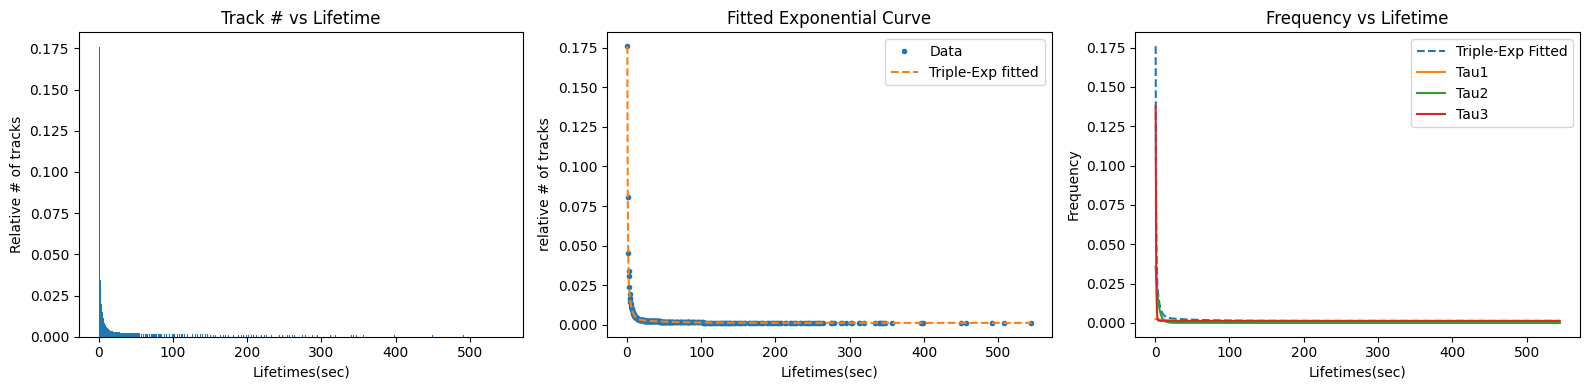

R^2 = 0.999999003160202
Total Track no = 2675


In [125]:
Fitting_result = pd.DataFrame(columns=["Tau1", "Tau2", "Amplitude1", "Amplitude2", "rSquared", "b2", "Integral"])

# Wrangle Imaris measured data and Concatenate them together--------------------------------------------------------------------------------------------------------
for key, value in Files.items():
  if key == "Fast":
    Raw_path = Raw_path_fast
    Interval = Interval_fast
  elif key == "Slow":
    Raw_path = Raw_path_slow
    Interval = Interval_slow
  Group_DF = pd.DataFrame()
  for i in value:
    Table_Raw = pd.read_excel(os.path.join(Raw_path,i), sheet_name=["Time Index", "Track Duration", "Track Number of Spots"], header = 1)
    # New architecture
    Temp_DF = Table_Raw["Track Duration"]
    Temp_DF["Track number of Spots"] = Table_Raw["Track Number of Spots"]["Track Number of Spots"]
    # Filter the tracks crossing over head and end
    Time_min = Table_Raw["Time Index"]["Time Index"].min()
    Time_max = Table_Raw["Time Index"]["Time Index"].max()
    Movie_length = Time_max - Time_min + 1
    Outlier_ID = (Table_Raw["Time Index"]["Time Index"] <= Time_min) |(Table_Raw["Time Index"]["Time Index"] >= Time_max)
    Outlier_ID = set(Table_Raw["Time Index"]["TrackID"][Outlier_ID])
    Final = Temp_DF[~Temp_DF["ID"].isin(Outlier_ID)]
    # Collect the final data
    Track_Summary = Final.copy()
    Track_Summary["Measured Track No"] = 1
    Track_Summary = Track_Summary.groupby("Track Duration").sum().reset_index()
    Track_Summary = Track_Summary.drop(columns = ["ID", "Unit", "Category"])
    Track_Summary["cf"] = Movie_length/(Movie_length -1 -Track_Summary["Track Duration"])
    Track_Summary["Corrected Track No"] = Track_Summary["Measured Track No"]*Track_Summary["cf"]
    # Fetch time interval from variable "Interval"
    Track_Summary["Time_interval"] = Interval
    Track_Summary["Lifetime"] = Track_Summary["Track Duration"]*Interval
    Track_Summary["Normalized spots population"] = Track_Summary["Track number of Spots"].apply(lambda x: x/Track_Summary["Track number of Spots"].sum())
    Track_Summary["Normalized track population"] = Track_Summary["Corrected Track No"].apply(lambda x: x/ Track_Summary["Corrected Track No"].sum())
    Track_Summary["Name"] = i
    # Save result to Group_DF
    Group_DF = pd.concat([Group_DF, Track_Summary])
  Group_DF.to_excel(f"/content/drive/MyDrive/CCP_assay/Concate_DF_{Interval}.xlsx")

# Get probability density function (PDF) from each group --------------------------------------------------------------------------------------------------------------------------------------
  # Merge track data by "Track duration" and get PDF
  Merged_Track = Group_DF.groupby("Track Duration").sum().reset_index()
  Merged_Track["Lifetime"] = Merged_Track["Track Duration"]*Interval
  Merged_Track["Normalized track population"] = Merged_Track["Corrected Track No"].apply(lambda x: x/Merged_Track["Corrected Track No"].sum())
  Merged_Track = Merged_Track.drop(columns=["Track number of Spots", "cf", "Normalized spots population"])
  Merged_Track.to_excel(f"/content/drive/MyDrive/CCP_assay/Merged_Track_{Interval}.xlsx", index=False)

  ## Fitting: dualexponential fit
  xs = Merged_Track["Lifetime"]
  ys = Merged_Track["Normalized track population"]
  p0 = (Merged_Track["Normalized track population"].max(), .1, Merged_Track["Normalized track population"].max(), .1,0) # start with values near those we expect
  poptd, cvd = scipy.optimize.curve_fit(duExp, xs, ys, p0, bounds=((-np.inf, 0, -np.inf, 0, -np.inf),(np.inf, np.inf, np.inf, np.inf, np.inf)))## restrict Tau1 and Tau2 between 0 and Inf. to avoid overflow !!
  a1d, t1d, a2d, t2d, b2 = poptd
  tau1dSec = (1 / t1d)
  tau2dSec = (1 / t2d)

  # determine quality of the dualexponential fit
  squaredDiffs = np.square(ys - duExp(xs, a1d, t1d, a2d, t2d, b2))
  squaredDiffsFromMean = np.square(ys - np.mean(ys))
  rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)

  # Intergal 30 to 50
  f1 = lambda x : a1d * np.exp(-t1d *x) + a2d * np.exp(-t2d * x) + b2
  area = integrate.quad(f1, 30, 50)

  # Save the the fitting result
  Fitting_result.loc[0]=[tau1dSec, tau2dSec, a1d, a2d, rSquared, b2, area[0]]
  with pd.ExcelWriter(f"/content/drive/MyDrive/CCP_assay/Fitting_integral_{Interval}.xlsx") as writer:
    Merged_Track.to_excel(writer, sheet_name="Merged_Track")
    Fitting_result.to_excel(writer, sheet_name="Fitting_result")

# Normalize two PDFs and give fitting results from the normalized data -------------------------------------------------------------------------------------------------------------------------------------------
# Reload data and Calculate alpha
Path_Merged_Track_Fast = (f"/content/drive/MyDrive/CCP_assay/Fitting_integral_{Interval_fast}.xlsx")
Path_Merged_Track_Slow = (f"/content/drive/MyDrive/CCP_assay/Fitting_integral_{Interval_slow}.xlsx")
Merged_Track_Fast = pd.read_excel(Path_Merged_Track_Fast, sheet_name = ["Merged_Track","Fitting_result"], header = 0,index_col = 0)
Merged_Track_Slow = pd.read_excel(Path_Merged_Track_Slow, sheet_name = ["Merged_Track","Fitting_result"], header = 0, index_col = 0)
Table_Raw_Fast = Merged_Track_Fast["Merged_Track"].copy()
Table_Raw_Slow = Merged_Track_Slow["Merged_Track"].copy()
Nfast = Table_Raw_Fast['Measured Track No'].sum()
Nslow = Table_Raw_Slow['Measured Track No'].sum()
Nall = Nfast + Nslow
alph = Merged_Track_Slow["Fitting_result"].iat[0,6]/Merged_Track_Fast["Fitting_result"].iat[0,6]

# Normalize F(t) with alpha
Table_Raw_Fast["Normalized track population"] = Merged_Track_Fast["Merged_Track"]["Normalized track population"] * alph

## Fitting: dualexponential fit - To renew function of normalized Table_Raw_Fast
xs = Table_Raw_Fast["Lifetime"]
ys = Table_Raw_Fast["Normalized track population"]
p0 = (Table_Raw_Fast["Normalized track population"].max(), .1, Table_Raw_Fast["Normalized track population"].max(), .1,0) # start with values near those we expect
poptd, cvd = scipy.optimize.curve_fit(duExp, xs, ys, p0, bounds=((-np.inf, 0, -np.inf, 0, -np.inf),(np.inf, np.inf, np.inf, np.inf, np.inf)))## restrict Tau1 and Tau2 between 0 and Inf. to avoid overflow !!
a1d, t1d, a2d, t2d, b2 = poptd
tau1dSec = (1 / t1d)
tau2dSec = (1 / t2d)
# Determine quality of the dualexponential fit
squaredDiffs = np.square(ys - duExp(xs, a1d, t1d, a2d, t2d, b2))
squaredDiffsFromMean = np.square(ys - np.mean(ys))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
Merged_Track_Fast["Fitting_result"].loc[0] = [tau1dSec, tau2dSec, a1d, a2d, rSquared, b2, 0.0]

# Create the datapoints
Normalized_df = pd.concat([Table_Raw_Fast, Table_Raw_Slow])
Normalized_df = Normalized_df.drop(columns = ["Track Duration", "Corrected Track No", "Normalized track population","Time_interval"])
Normalized_df.sort_values(by = ["Lifetime"], inplace = True, ignore_index = True)

# Get Normalized F(t)
Normalized_df["Population from F(t)"] = duExp(Normalized_df["Lifetime"], a1d, t1d, a2d, t2d, b2)

# Get Normalized S(t)
Fitting_slow = Merged_Track_Slow["Fitting_result"].loc[0]
Normalized_df["Population from S(t)"] = duExp(Normalized_df["Lifetime"], Fitting_slow.iloc[2], 1/Fitting_slow.iloc[0], Fitting_slow.iloc[3], 1/Fitting_slow.iloc[1], Fitting_slow.iloc[5])
Normalized_df['Histogram merged population'] = Normalized_df["Population from F(t)"] + Normalized_df["Population from S(t)"]
Normalized_df["Normalized track population"] = Normalized_df["Histogram merged population"] / Normalized_df["Histogram merged population"].sum()
#Normalized_df.to_excel(f"/content/drive/MyDrive/CCP_assay/Normalized_df_{Interval_fast}to{Interval_slow}.xlsx")
#Normalized_df

# Data Visualization -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Plot relative # of tracks vs lifetime
Triple_Exp_R = plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
xs = Normalized_df["Lifetime"]
ys = Normalized_df["Normalized track population"]
plt.bar(xs,ys)
plt.xlabel("Lifetimes(sec)")
plt.ylabel("Relative # of tracks")
plt.title("Track # vs Lifetime")
## Fitting: Triple exponential fit
xs = Normalized_df["Lifetime"]
ys = Normalized_df["Normalized track population"]
p0 = (Normalized_df['Normalized track population'].max(), 0.02, Normalized_df['Normalized track population'].max(), 0.25,Normalized_df['Normalized track population'].max(), 1.25,0) # start with values near those we expect
poptt, cvt = scipy.optimize.curve_fit(tpExp, xs, ys , p0, bounds = ((-np.inf, 0, -np.inf, 0, -np.inf, 0, -np.inf),(np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf)))#optimized parameters and covariants
a1t, t1t, a2t, t2t, a3t, t3t, b3 = poptt
tau1tSec = (1 / t1t)
tau2tSec = (1 / t2t)
tau3tSec = (1 / t3t)

# Determine quality of the triple exponential fit
squaredDiffs = np.square(ys - tpExp(xs, a1t, t1t, a2t, t2t, a3t, t3t, b3))
squaredDiffsFromMean = np.square(ys - np.mean(ys))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
tpxExp_para = pd.DataFrame(columns=["Tau1", "Tau2", "Tau3", "Amplitude1", "Amplitude2", "Amplitude3", "b3", "rSquared"])
tpxExp_para.loc[0] = [tau1tSec, tau2tSec, tau3tSec, a1t, a2t, a3t, b3,rSquared]

# Save the the fitting result
with pd.ExcelWriter(f"/content/drive/MyDrive/CCP_assay/Normalized_df_{Interval_fast}to{Interval_slow}.xlsx") as writer:
  Normalized_df.to_excel(writer, sheet_name="Normalized_df")
  tpxExp_para.to_excel(writer, sheet_name="Fitting_result")

# Plot the result of Triple exponential fitting
plt.subplot(1,3,2)# Triple-ExP Fitting cureve
xs = Normalized_df["Lifetime"]
ys = Normalized_df["Normalized track population"]
plt.plot(xs, ys, '.', label="Data")
plt.plot(xs, tpExp(xs, a1t, t1t, a2t, t2t, a3t, t3t, b3), '--', label="Triple-Exp fitted")
plt.xlabel("Lifetimes(sec)")
plt.ylabel("relative # of tracks")
plt.title("Fitted Exponential Curve")
plt.legend()

# Plot frequency vs lifetime of the triple exponential model
plt.subplot(1,3,3)
plt.plot(xs, tpExp(xs, a1t, t1t, a2t, t2t, a3t, t3t, b3), '--', label="Triple-Exp Fitted")
plt.plot(xs, monoExp(xs, a1t, t1t,0), '-', label="Tau1")
plt.plot(xs, monoExp(xs, a2t, t2t,0), '-', label="Tau2")
plt.plot(xs, monoExp(xs, a3t, t3t,b3), '-', label="Tau3")
plt.xlabel("Lifetimes(sec)")
plt.ylabel("Frequency")
plt.title("Frequency vs Lifetime")
plt.legend()
plt.tight_layout()
plt.show()
print(f'R^2 = {rSquared}')
print(f'Total Track no = {Nall}')

#Normalized_df


# 2. Calculate relative contribution, mean and standard deviation of each component

The first crossing point = 2.148521536953639
The second crossing point = 11.23491537619547


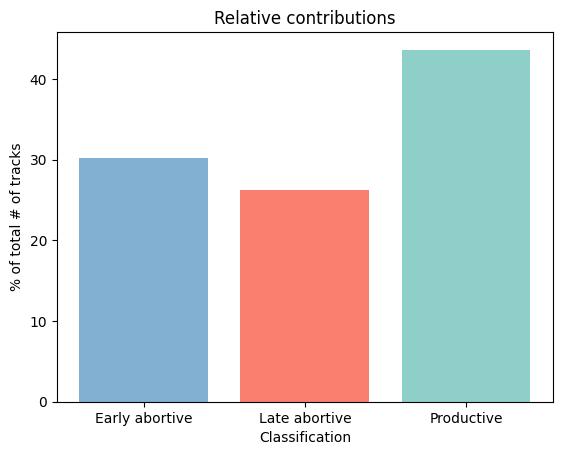

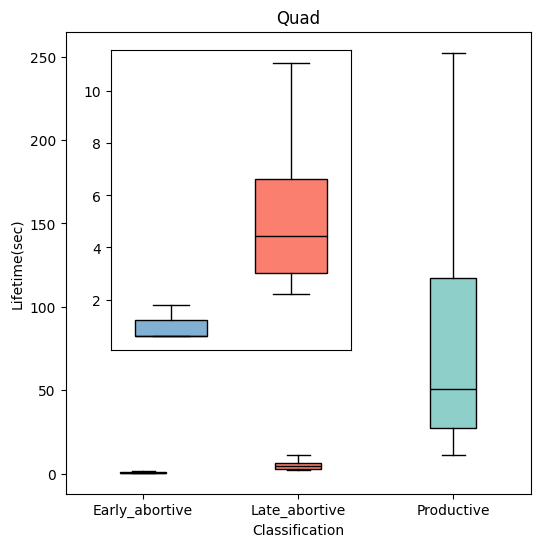

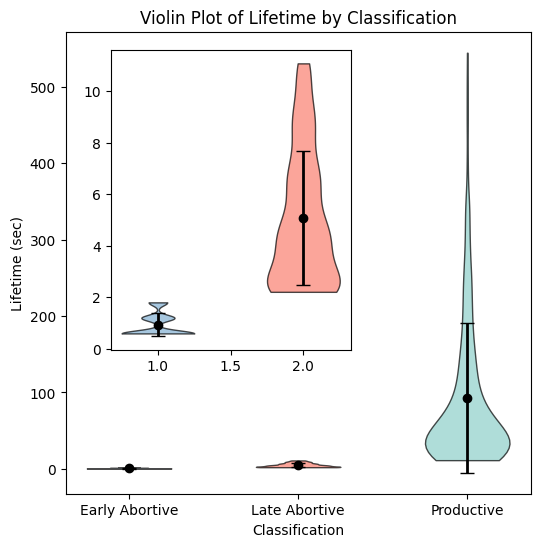

,Classification,Normalized track population,Corrected Track No,Lifetime mean,Std
0,Early abortive,0.301718,807.094700,0.943268,0.444606
1,Late abortive,0.262122,701.175872,5.075320,2.595628
2,Productive,0.436161,1166.729428,92.996683,98.016983


In [126]:
# Define critical points between components -----------------------------------------------------------------------------------------------------------------------------------
# Get the parameters for each classification
tpxExp_para.insert(6,"b1",0)
tpxExp_para.insert(7,"b2",0)
tpxExp_para = tpxExp_para.drop(columns=["rSquared"])
Tau_df = pd.DataFrame(tpxExp_para.values.reshape(-1,3))
Tau_df = pd.concat([Tau_df.iloc[0:2,:],(Tau_df.iloc[0:1].apply(lambda x: 1/x)),Tau_df.iloc[2:]], axis=0, ignore_index= True)
Tau_df = Tau_df.sort_values(by=0, axis=1, ascending = False)
Tau_df.rename(columns={0:"Productive", 1:"Late abortive", 2:"Early abortive"}, inplace=True)
Tau_df.insert(0, "Parameter", ["Tau", "a", "t", "b"])

# Calculate the critical point (cross point)
xc1 = (np.log(Tau_df.iat[1,2])-np.log(Tau_df.iat[1,3])-np.log(Tau_df.iat[3,3]))/(Tau_df.iat[2,3]+Tau_df.iat[2,2])
print(f'The first crossing point = {xc1}')
xc2 = (np.log(Tau_df.iat[1,1])-np.log(Tau_df.iat[1,2]))/(Tau_df.iat[2,1]-Tau_df.iat[2,2])
print(f'The second crossing point = {xc2}')
Tau_df

# Classify
Normalized_df["Classification"] = Normalized_df["Lifetime"].apply(lambda x: "Early abortive" if x <= xc1 else("Late abortive" if x<= xc2 else "Productive"))

# Calculate relative contribution -------------------------------------------------------------------------------------------------------------------------------------------------
# Extract data
Table_Classify = Normalized_df.copy().groupby("Classification").sum().reset_index()
Table_Classify["Relative contributions"] = Table_Classify["Histogram merged population"].apply(lambda x: x*100/Table_Classify["Histogram merged population"].sum())
Table_Classify = Table_Classify.drop(columns=["Lifetime", "Name", "Population from F(t)", "Population from S(t)"])
# Plot
x = Table_Classify["Classification"]
y = Table_Classify["Relative contributions"]
Relative_contributions = plt.figure()
plt.bar(x,y, color = ["#82B0D2", "#FA7F6F", "#8ECFC9"])
plt.xlabel("Classification")
plt.ylabel("% of total # of tracks")
plt.title("Relative contributions")
plt.savefig(f"/content/drive/MyDrive/CCP_assay/Relative_contributions_{Interval_fast}to{Interval_slow}.png", facecolor='w', transparent = None, dpi = 300)
plt.show()

# Calculate mean of each component ------------------------------------------------------------------------------------------------------------------------------------------------
Normalized_df["Corrected Track No"] = Normalized_df["Normalized track population"] * Nall
Normalized_df["Lifetime * Corrected Track No"] = Normalized_df["Corrected Track No"] * Normalized_df["Lifetime"]
Table_Classify_Mean = Normalized_df.copy().groupby("Classification").sum().reset_index()
Table_Classify_Mean['Lifetime mean'] = Table_Classify_Mean['Lifetime * Corrected Track No'] / Table_Classify_Mean ['Corrected Track No']
Table_Classify_Mean = Table_Classify_Mean.drop(columns=["Measured Track No", "Lifetime", "Name", "Population from F(t)", "Population from S(t)", "Histogram merged population", "Lifetime * Corrected Track No"])
EarlyMean = Table_Classify_Mean['Lifetime mean'].iloc[0]
LateMean = Table_Classify_Mean['Lifetime mean'].iloc[1]
ProductiveMean = Table_Classify_Mean['Lifetime mean'].iloc[2]
means = [EarlyMean, LateMean, ProductiveMean]

# Calculate standard deviation of each component ----------------------------------------------------------------------------------------------------------------------------------
category_mapping = {
    'Early abortive': EarlyMean,
    'Late abortive': LateMean,
    'Productive': ProductiveMean
}
Normalized_df['Lifetime mean'] = Normalized_df['Classification'].map(category_mapping)
Normalized_df['Variance * N'] = Normalized_df['Corrected Track No'] * ((Normalized_df['Lifetime'] - Normalized_df['Lifetime mean']))**2
Table_Classify_Std = Normalized_df.copy().groupby('Classification').sum().reset_index()
Table_Classify_Std['Lifetime Std'] = np.sqrt(Table_Classify_Std['Variance * N'] / Table_Classify_Std['Corrected Track No'])
Table_Classify_Std = Table_Classify_Std.drop(columns=["Measured Track No", "Lifetime", "Name", "Population from F(t)", "Population from S(t)", "Histogram merged population", "Lifetime * Corrected Track No", "Variance * N", "Lifetime mean"])
EarlyStd = Table_Classify_Std['Lifetime Std'].iloc[0]
LateStd = Table_Classify_Std['Lifetime Std'].iloc[1]
ProductiveStd = Table_Classify_Std['Lifetime Std'].iloc[2]
std_devs = [EarlyStd, LateStd, ProductiveStd]

Normalized_df['Corrected Track No(R)'] = Normalized_df['Corrected Track No'].round(0)

# Save the final Normalized_df data
with pd.ExcelWriter(f"/content/drive/MyDrive/CCP_assay/Normalized_df_{Interval_fast}to{Interval_slow}.xlsx") as writer:
  Normalized_df.to_excel(writer, sheet_name="Normalized_df")
  Tau_df.to_excel(writer, sheet_name="Fitting_result")

Table_Classify_Mean
#Normalized_df

# Plot Boxplot ---------------------------------------------------------------------------------------------------------------------------------------------------------------------
df_expanded = Normalized_df.loc[Normalized_df.index.repeat(Normalized_df['Corrected Track No(R)'])].reset_index(drop=True)

# Split the data into three categories
df_early1 = df_expanded[df_expanded["Classification"]=="Early abortive"]
df_late1 = df_expanded[df_expanded["Classification"]=="Late abortive"]
df_productive1 = df_expanded[df_expanded["Classification"]=="Productive"]

# Plot
data = [df_early1['Lifetime'], df_late1['Lifetime'], df_productive1['Lifetime']]
Color = ['#82B0D2', '#FA7F6F', '#8ECFC9']
fig = plt.figure(figsize =(6, 6))

bp = plt.boxplot(data, tick_labels = ["Early_abortive", "Late_abortive", "Productive"],showfliers = False, patch_artist = True, medianprops = {'color': "black", 'linewidth': 1})
for box, cr in zip(bp["boxes"], Color):
    box.set_facecolor(cr)
plt.xlabel("Classification")
plt.title("Quad")
plt.ylabel("Lifetime(sec)")

# 左上角子圖
ax = fig.add_axes([0.2, 0.35, 0.4 ,0.5])
Axex = plt.boxplot(data[0:2],  widths = 0.6, tick_labels=["",""],showfliers = False, patch_artist = True, medianprops = {'color': "black", 'linewidth': 1})
for box, cr in zip(Axex["boxes"], Color):
    box.set_facecolor(cr)
ax.tick_params(bottom = False)

plt.show()

# Plot violinplot -------------------------------------------------------------------------------------------------------------------------------------------------------------
# 創建小提琴圖
fig, ax = plt.subplots(figsize=(6, 6))

# 畫出每組數據的小提琴圖
violin_parts = ax.violinplot(data, showmeans=False, showmedians=False, showextrema=False)

# 加上標準差（以條形的形式）
for i in range(len(data)):
    ax.errorbar(x=i+1, y=means[i], yerr=std_devs[i], fmt='o', color='black',
                elinewidth=2, capsize=5, label=f'SD for {["Early Abortive", "Late Abortive", "Productive"][i]}')


for i in range(len(violin_parts['bodies'])):
    violin_parts['bodies'][i].set_facecolor(Color[i])  # 設定顏色
    violin_parts['bodies'][i].set_edgecolor('black')  # 設定邊緣顏色（選擇黑色）
    violin_parts['bodies'][i].set_alpha(0.7)  # 設定透明度

# 設置x軸標籤
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Early Abortive', 'Late Abortive', 'Productive'])

# 添加標題和標籤
plt.title('Violin Plot of Lifetime by Classification')
plt.xlabel('Classification')
plt.ylabel('Lifetime (sec)')

# 左上角子圖
ax = fig.add_axes([0.2, 0.35, 0.4 ,0.5])
violin_parts = ax.violinplot(data[0:2], showmeans=False, showmedians=False, showextrema=False)

# 加上標準差（以條形的形式）
for i in range(2):
    ax.errorbar(x=i+1, y=means[i], yerr=std_devs[i], fmt='o', color='black',
                elinewidth=2, capsize=5, label=f'SD for {["Early Abortive", "Late Abortive", "Productive"][i]}')

for i in range(len(violin_parts['bodies'])):
    violin_parts['bodies'][i].set_facecolor(Color[i])  # 設定顏色
    violin_parts['bodies'][i].set_edgecolor('black')  # 設定邊緣顏色（選擇黑色）
    violin_parts['bodies'][i].set_alpha(0.7)  # 設定透明度

# 顯示圖形
plt.show()

Table_Classify_Mean["Std"] = std_devs
Table_Classify_Mean